# Modelling K2-24 with `simppler`

This is a reproduction of the [RadVel tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting%2BMCMC.html) on the same dataset.
Hopefully this can provide a useful comparison between how to implement similar models with the two packages (note that `simppler` models have a `.to_radvel()` method to easily convert models).

## Importing the data

Let us first load the K2-24 observations directly from the RadVel repository, extract the relevant columns, and display it.

In [1]:
from pandas import read_csv

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/refs/heads/master/example_data/epic203771098.csv"
df = read_csv(url, index_col=0)
df.head()

errvel            t        vel
0  1.593725  2364.819580   6.959066
1  1.600745  2364.825101   5.017650
2  1.658815  2364.830703  13.811799
3  1.653224  2366.827579   1.151030
4  1.639095  2367.852646   9.389273

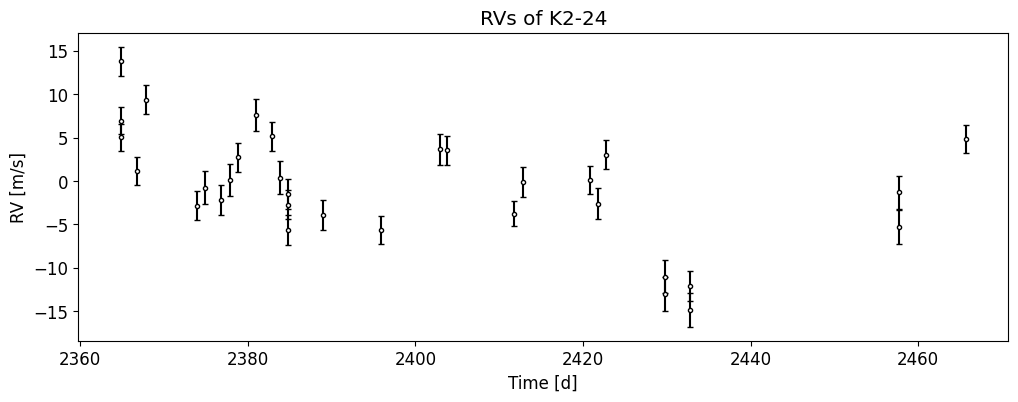

In [2]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams["font.size"] = 12.0

t = df.t.values
vel = df.vel.values
errvel = df.errvel.values

def plot_data():
    plt.figure(figsize=(12, 4))
    plt.errorbar(t, vel, yerr=errvel, fmt="k.", capsize=2, mfc="w", label="Data")
    plt.xlabel("Time [d]")
    plt.ylabel("RV [m/s]")
plot_data()
plt.title("RVs of K2-24")
plt.show()

## Building the model

To build a `simppler` model, we must first specify our parameters as prior distributions.

To follow the RadVel tutorial, we will fix some parameters.
`simpple` allows us to do this with a `Fixed` distribution in the prior.
Parameters with a fixed distribution will not be included in the model dimensions or keys by default, but are registered and passed to the forward model when needed.
See the [dedicated `simpple` tutorial](https://simpple.readthedocs.io/en/stable/tutorials/fixed-parameters.html) on this topic for more info.

We will use a builder function to easily create models with varying subsets of fixed parameters.

A few things to note:

- Models are created via `RVModel`
- The `RVModel` requires dictionary of parameter distributions
- The `RVModel` also requires:
    - The number of planets (2 in this case)
    - `t`, `rv` and `erv`: The RV data
    - The basis to be used for orbital parameters
    - Model times `tmod`, to be used when plotting model curves (optional, will be set to `t` by default)
    - `time_base`, to be used as reference point for the trend component of the model (optional, 0 by default)

In [3]:
import numpy as np
import simppler.model as smod
from simpple import distributions as sdist
periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
def build_model(vary):
    # TODO: Eccentricity constraint
    if vary == "all":
        parameters = {
            "per1": sdist.Normal(periods[0], period_errs[0]),
            "tc1": sdist.Normal(t0s[0], t0_errs[0]),
            "secosw1": sdist.Uniform(-1, 1),
            "sesinw1": sdist.Uniform(-1, 1),
            "logk1": sdist.Normal(np.log(5), 10),
            "per2": sdist.Normal(periods[1], period_errs[1]),
            "tc2": sdist.Normal(t0s[1], t0_errs[1]),
            "secosw2": sdist.Uniform(-1, 1),
            "sesinw2": sdist.Uniform(-1, 1),
            "logk2": sdist.Normal(np.log(5), 10),
            "gamma": sdist.Normal(0, 10.0),
            "dvdt": sdist.Normal(0, 1.0),
            "curv": sdist.Normal(0, 1e-1),
            "jit": sdist.Normal(np.log(3), 0.5),
        }
    elif vary == "ecc":
        parameters = {
            "per1": sdist.Fixed(periods[0]),
            "tc1": sdist.Fixed(t0s[0]),
            "secosw1": sdist.Uniform(-1, 1),
            "sesinw1": sdist.Uniform(-1, 1),
            "logk1": sdist.Normal(np.log(5), 10),
            "per2": sdist.Fixed(periods[1]),
            "tc2": sdist.Fixed(t0s[1]),
            "secosw2": sdist.Uniform(-1, 1),
            "sesinw2": sdist.Uniform(-1, 1),
            "logk2": sdist.Normal(np.log(5), 10),
            "gamma": sdist.Normal(0, 10.0),
            "dvdt": sdist.Normal(0, 1.0),
            "curv": sdist.Normal(0, 1e-1),
            "jit": sdist.Normal(np.log(3), 0.5),
        }
    else:
        parameters = {
            "per1": sdist.Fixed(periods[0]),
            "tc1": sdist.Fixed(t0s[0]),
            "secosw1": sdist.Fixed(0.01),
            "sesinw1": sdist.Fixed(0.01),
            "logk1": sdist.Normal(np.log(5), 10),
            "per2": sdist.Fixed(periods[1]),
            "tc2": sdist.Fixed(t0s[1]),
            "secosw2": sdist.Fixed(0.01),
            "sesinw2": sdist.Fixed(0.01),
            "logk2": sdist.Normal(np.log(5), 10),
            "gamma": sdist.Normal(0, 10.0),
            "dvdt": sdist.Normal(0, 1.0),
            "curv": sdist.Normal(0, 1e-1),
            "jit": sdist.Normal(np.log(3), 0.5),
        }
    tmod = np.linspace(t.min() - 5, t.max() + 5, num=1000)
    time_base = 2420
    return smod.RVModel(parameters, 2, t, vel, errvel, basis="per tc secosw sesinw logk", tmod=tmod, time_base=time_base)

/home/vandal/miniforge3/envs/simppler/lib/python3.13/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


## Circular model

Let us start by building a circular model and plotting it with test parameter values.
The `simppler.plot` module has a few utility functions to plot RV data and models from an `RVModel`.

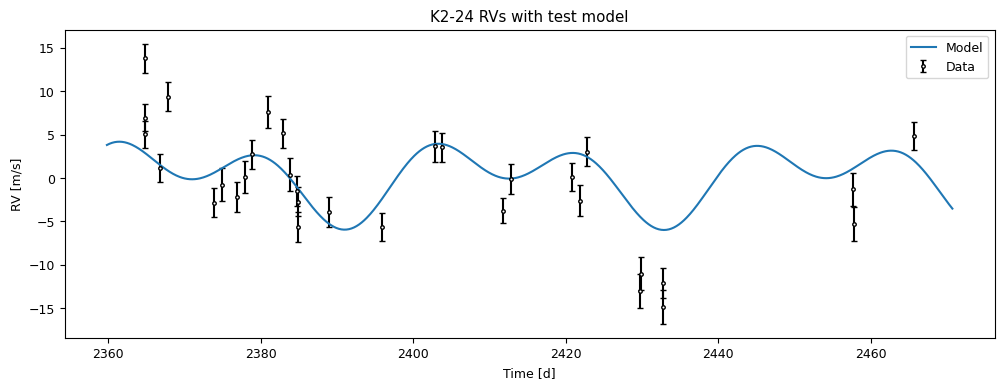

In [4]:
from simppler.plot import plot_rv, plot_phase

model = build_model("circular")
test_p = {"per1": periods[0], "tc1": t0s[0], "secosw1": 0.01, "sesinw1": 0.01, "logk1": 1.1}
test_p |= {"per2": periods[1], "tc2": t0s[1], "secosw2": 0.01, "sesinw2": 0.01, "logk2": 1.1}
test_p |= {"gamma": -10, "dvdt": -0.02, "curv": 0.01, "jit": 1.0}
plot_rv(model, parameters=test_p, residuals=False)
plt.title("K2-24 RVs with test model")
plt.show()

In [5]:
model.log_likelihood(test_p)
model.log_prob(test_p)

np.float64(-418.48109031025376)

### Optimization

Let us start by doing a simple maximum a posteriori (MAP) estimate.

In [6]:
from scipy.optimize import minimize

vary_p = {p: v for p, v in test_p.items() if p in model.vary_p}
res = minimize(lambda p: - model.log_prob(p), np.array(list(vary_p.values())), method="Nelder-Mead")

In [7]:
opt_p = dict(zip(model.keys(), res.x))

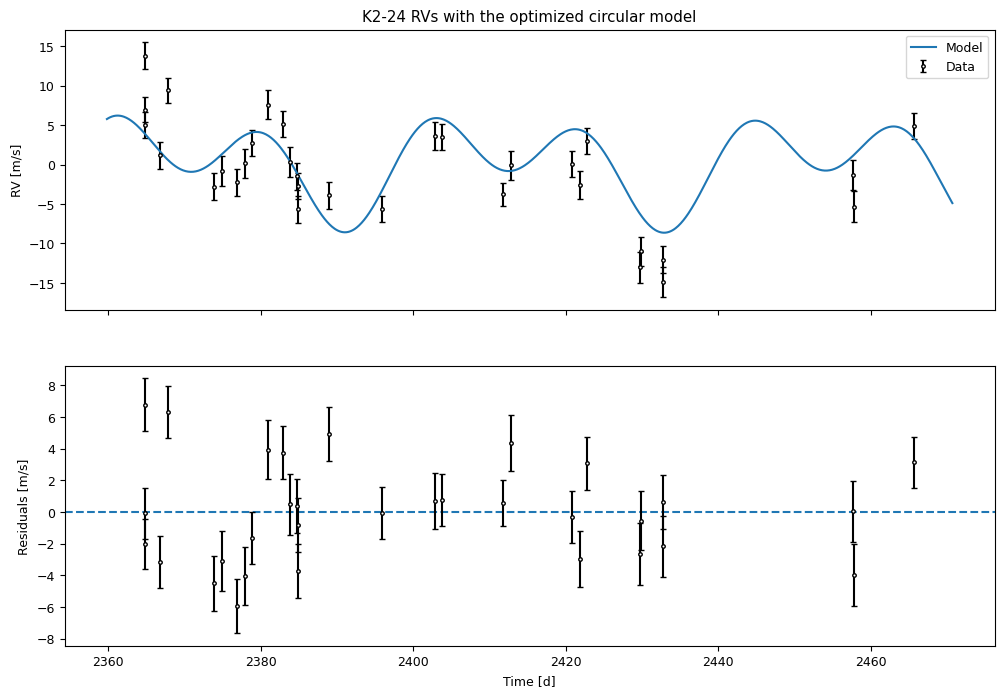

In [8]:
fig, axs = plot_rv(model, opt_p)
axs[0].set_title("K2-24 RVs with the optimized circular model")
plt.show()

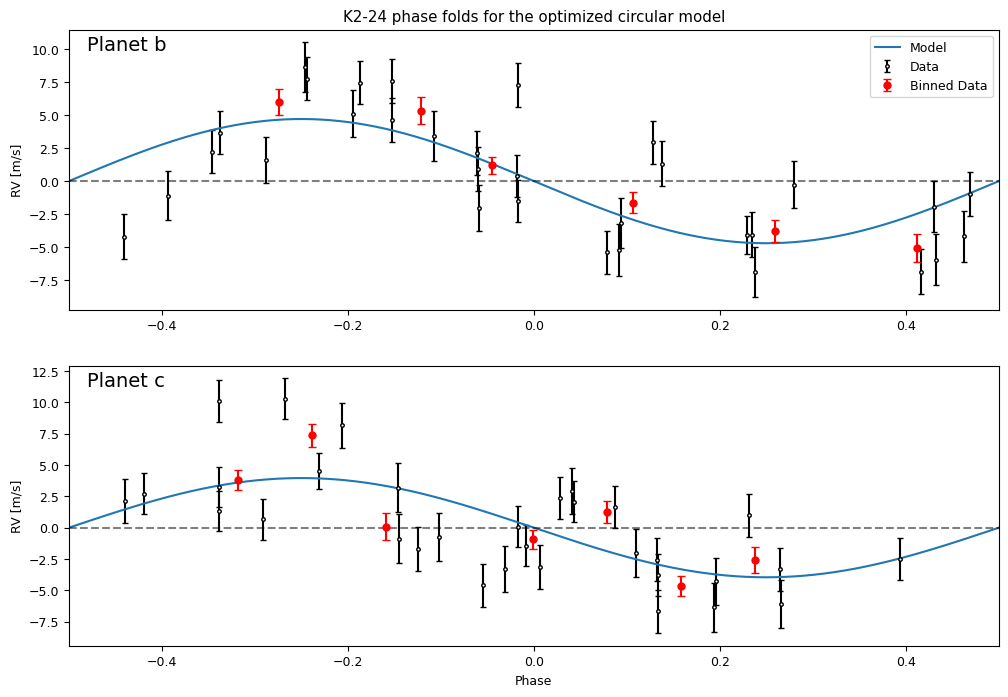

In [9]:
fig, axs = plot_phase(model, opt_p)
axs[0].set_title("K2-24 phase folds for the optimized circular model")
plt.show()

### Sampling

We can also do MCMC sampling for our circular model.

In [10]:
import emcee

nwalkers = 50
nsteps = 10_000
ndim = model.ndim
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_prob)

In [11]:
rng = np.random.default_rng()
p0 = res.x + 1e-4 * rng.normal(size=(nwalkers, ndim))
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:33<00:00, 107.36it/s]


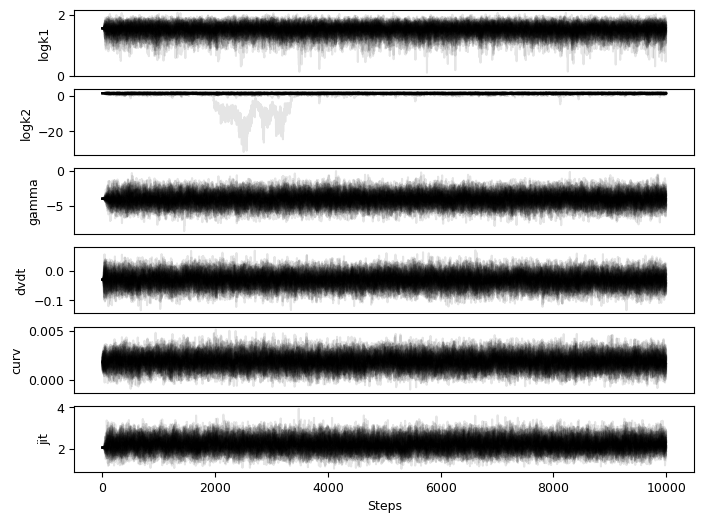

In [12]:
from simpple.plot import chainplot
chainplot(sampler.get_chain(), labels=model.keys())
plt.show()

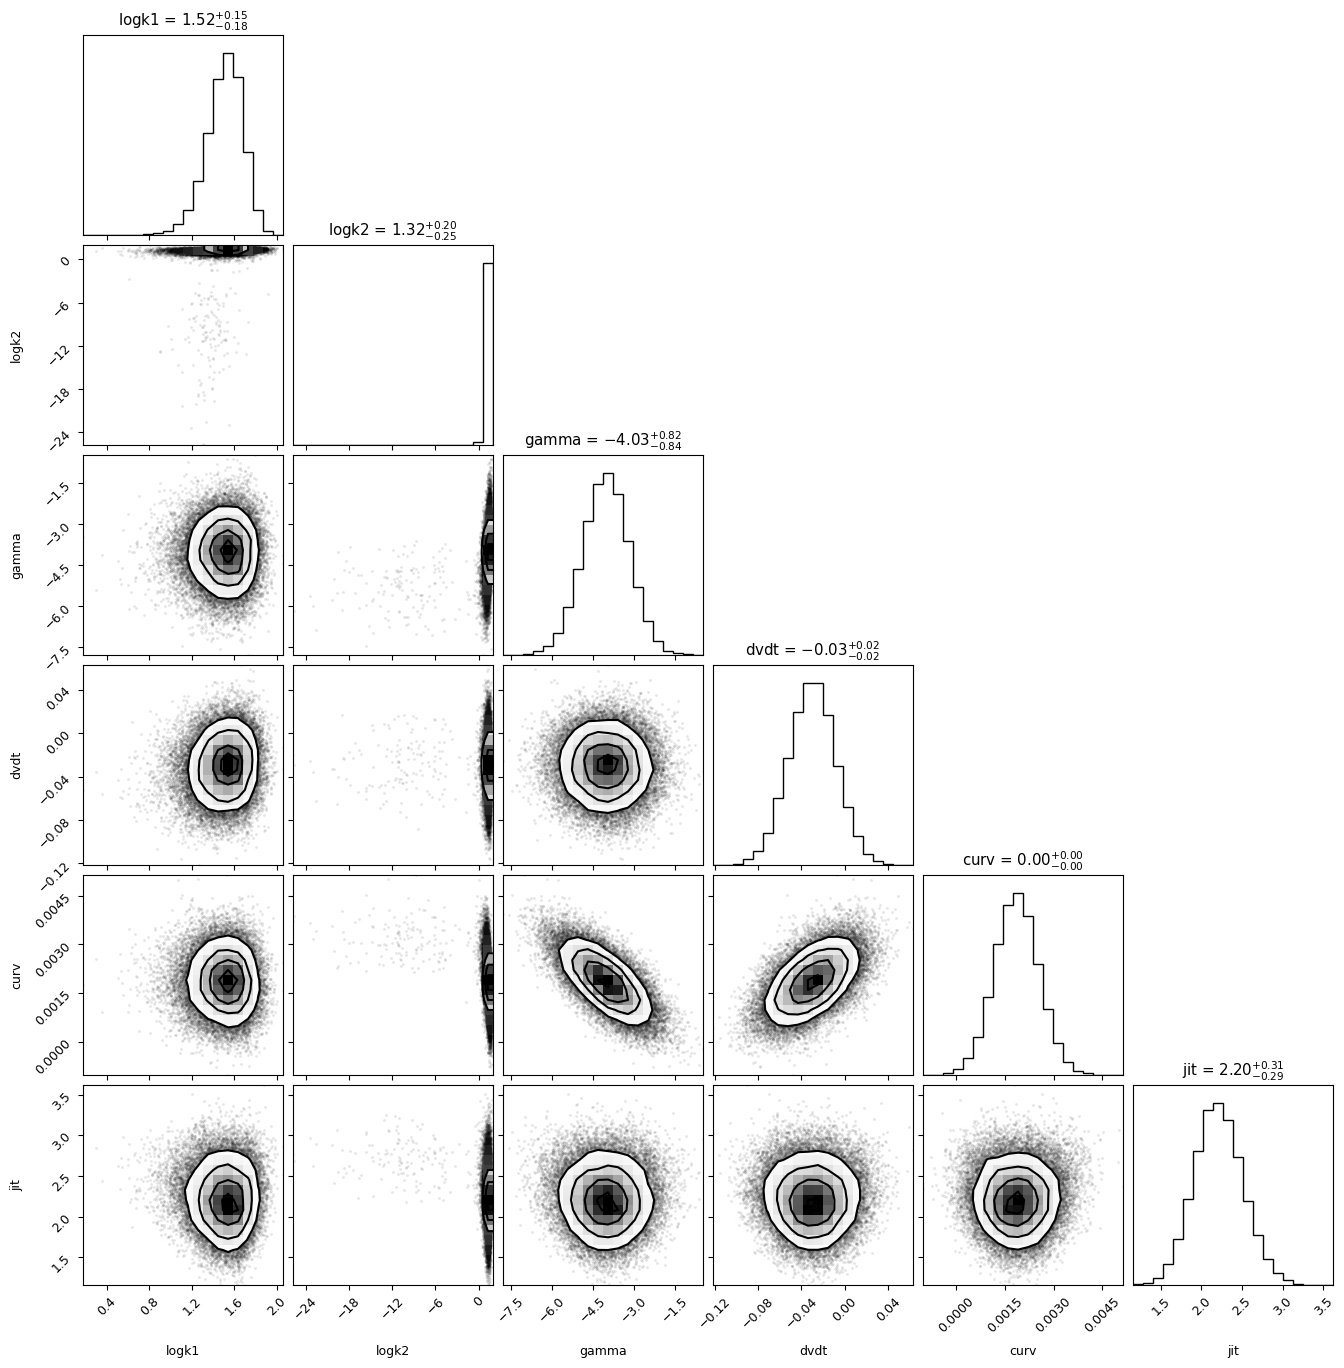

In [13]:
import corner
chains = sampler.get_chain(discard=2000, flat=True, thin=10)
corner.corner(chains, labels=model.keys(), show_titles=True)
plt.show()

The `plot_rv` and `plot_phase` functions also accept MCMC chains as input.
By default they will display 100 samples from the chain.


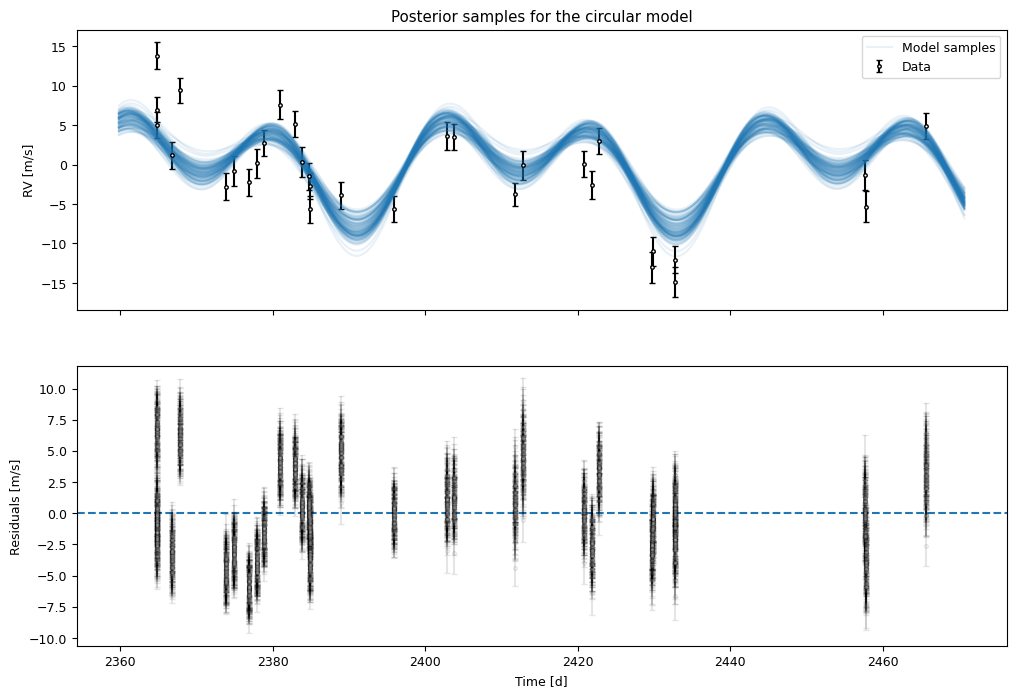

In [14]:
fig, axs = plot_rv(model, chains.T, n_samples=100)
axs[0].set_title("Posterior samples for the circular model")
plt.show()

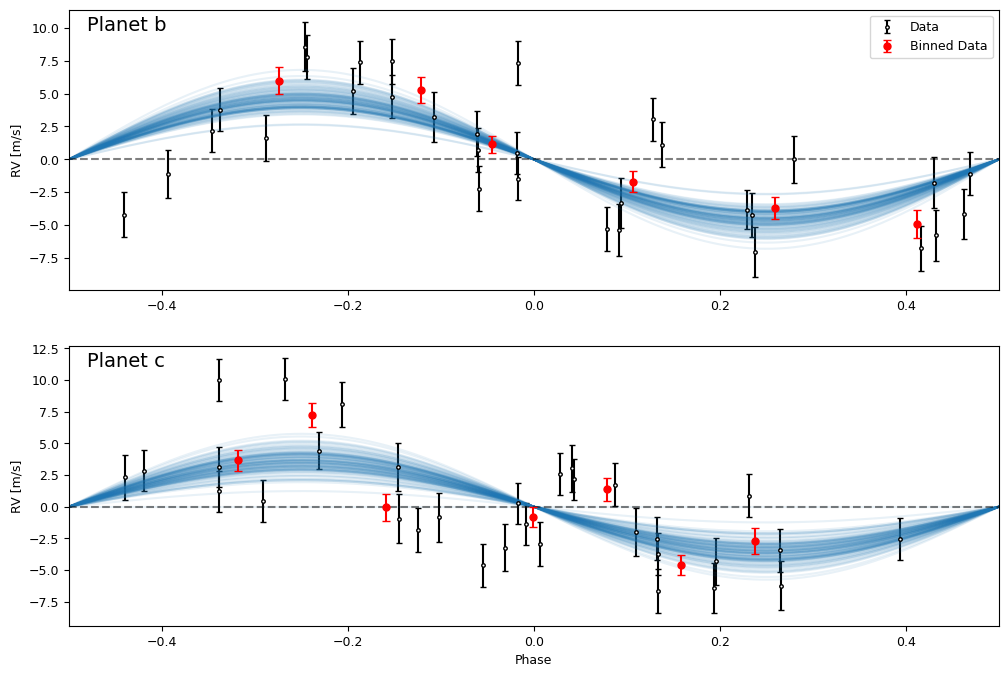

In [15]:
plot_phase(model, chains.T, n_samples=100)
axs[0].set_title("Phase-folded posterior samples for the circular model")

plt.show()

## Eccentric orbits

Let us now repeat all the steps we did for the circular model, but for an eccentric model.

In [16]:
model = build_model("ecc")

### Optimization

In [17]:
vary_p = {p: v for p, v in test_p.items() if p in model.vary_p}
res = minimize(lambda p: - model.log_prob(p), np.array(list(vary_p.values())), method="Powell")

invalid value encountered in scalar multiply


In [18]:
opt_p = dict(zip(model.keys(), res.x))

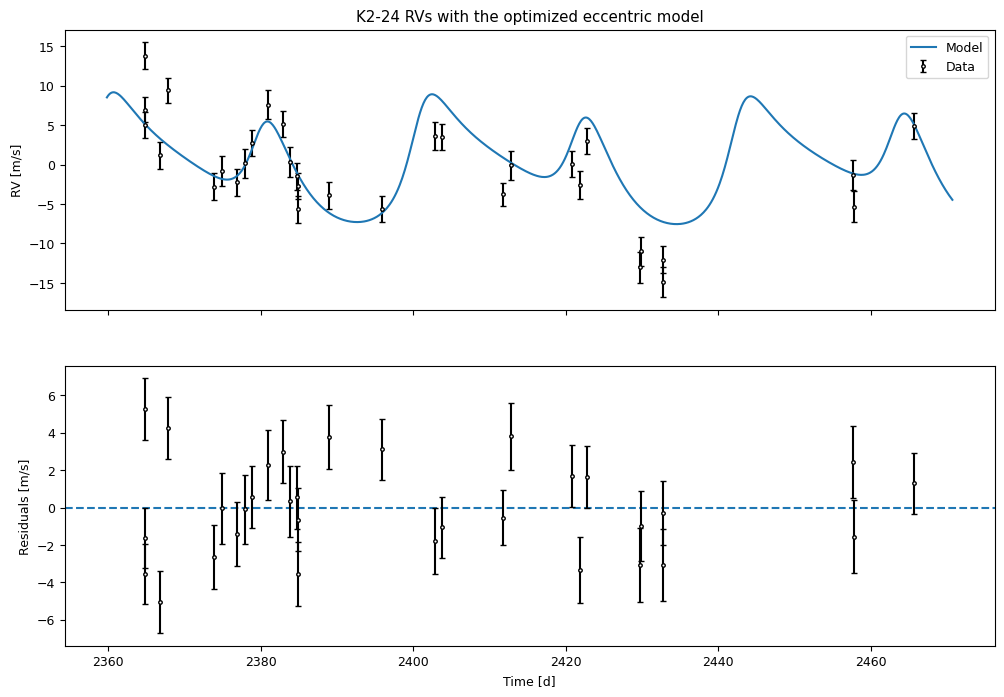

In [19]:
fig, axs = plot_rv(model, opt_p)
axs[0].set_title("K2-24 RVs with the optimized eccentric model")
plt.show()

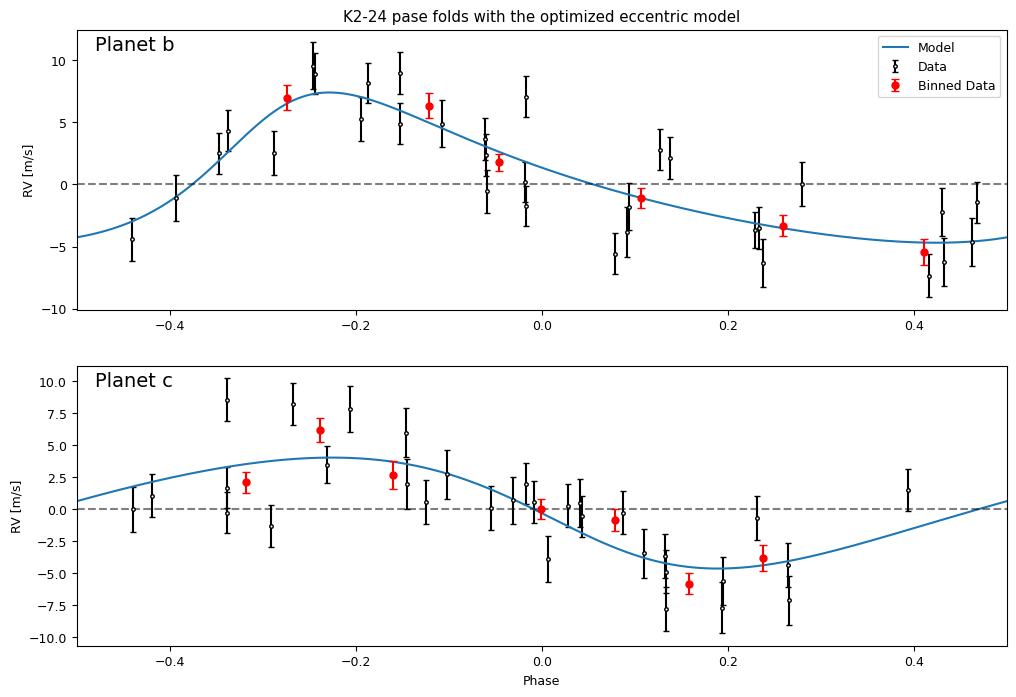

In [20]:
fig, axs = plot_phase(model, opt_p)
axs[0].set_title("K2-24 pase folds with the optimized eccentric model")
plt.show()

The optimized model looks like it provides a better fit to the data. Let us now explore the posterior a bit more with MCMC.

### Sampling

In [21]:
import emcee

nwalkers = 50
nsteps = 10_000
ndim = model.ndim
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_prob)

In [22]:
rng = np.random.default_rng()
p0 = res.x + 1e-4 * rng.normal(size=(nwalkers, ndim))
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:48<00:00, 92.47it/s]


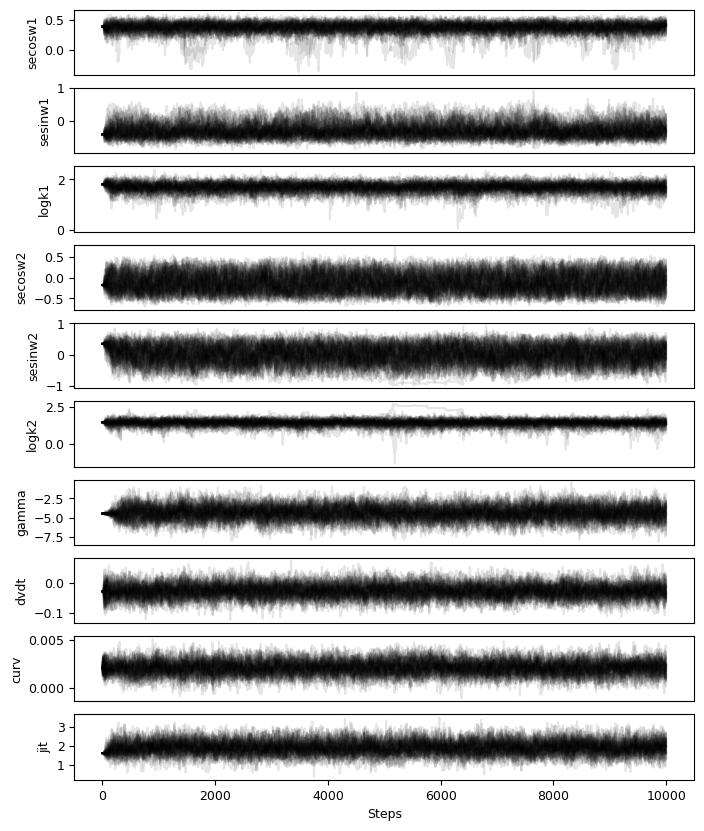

In [23]:
chainplot(sampler.get_chain(), labels=model.keys())
plt.show()

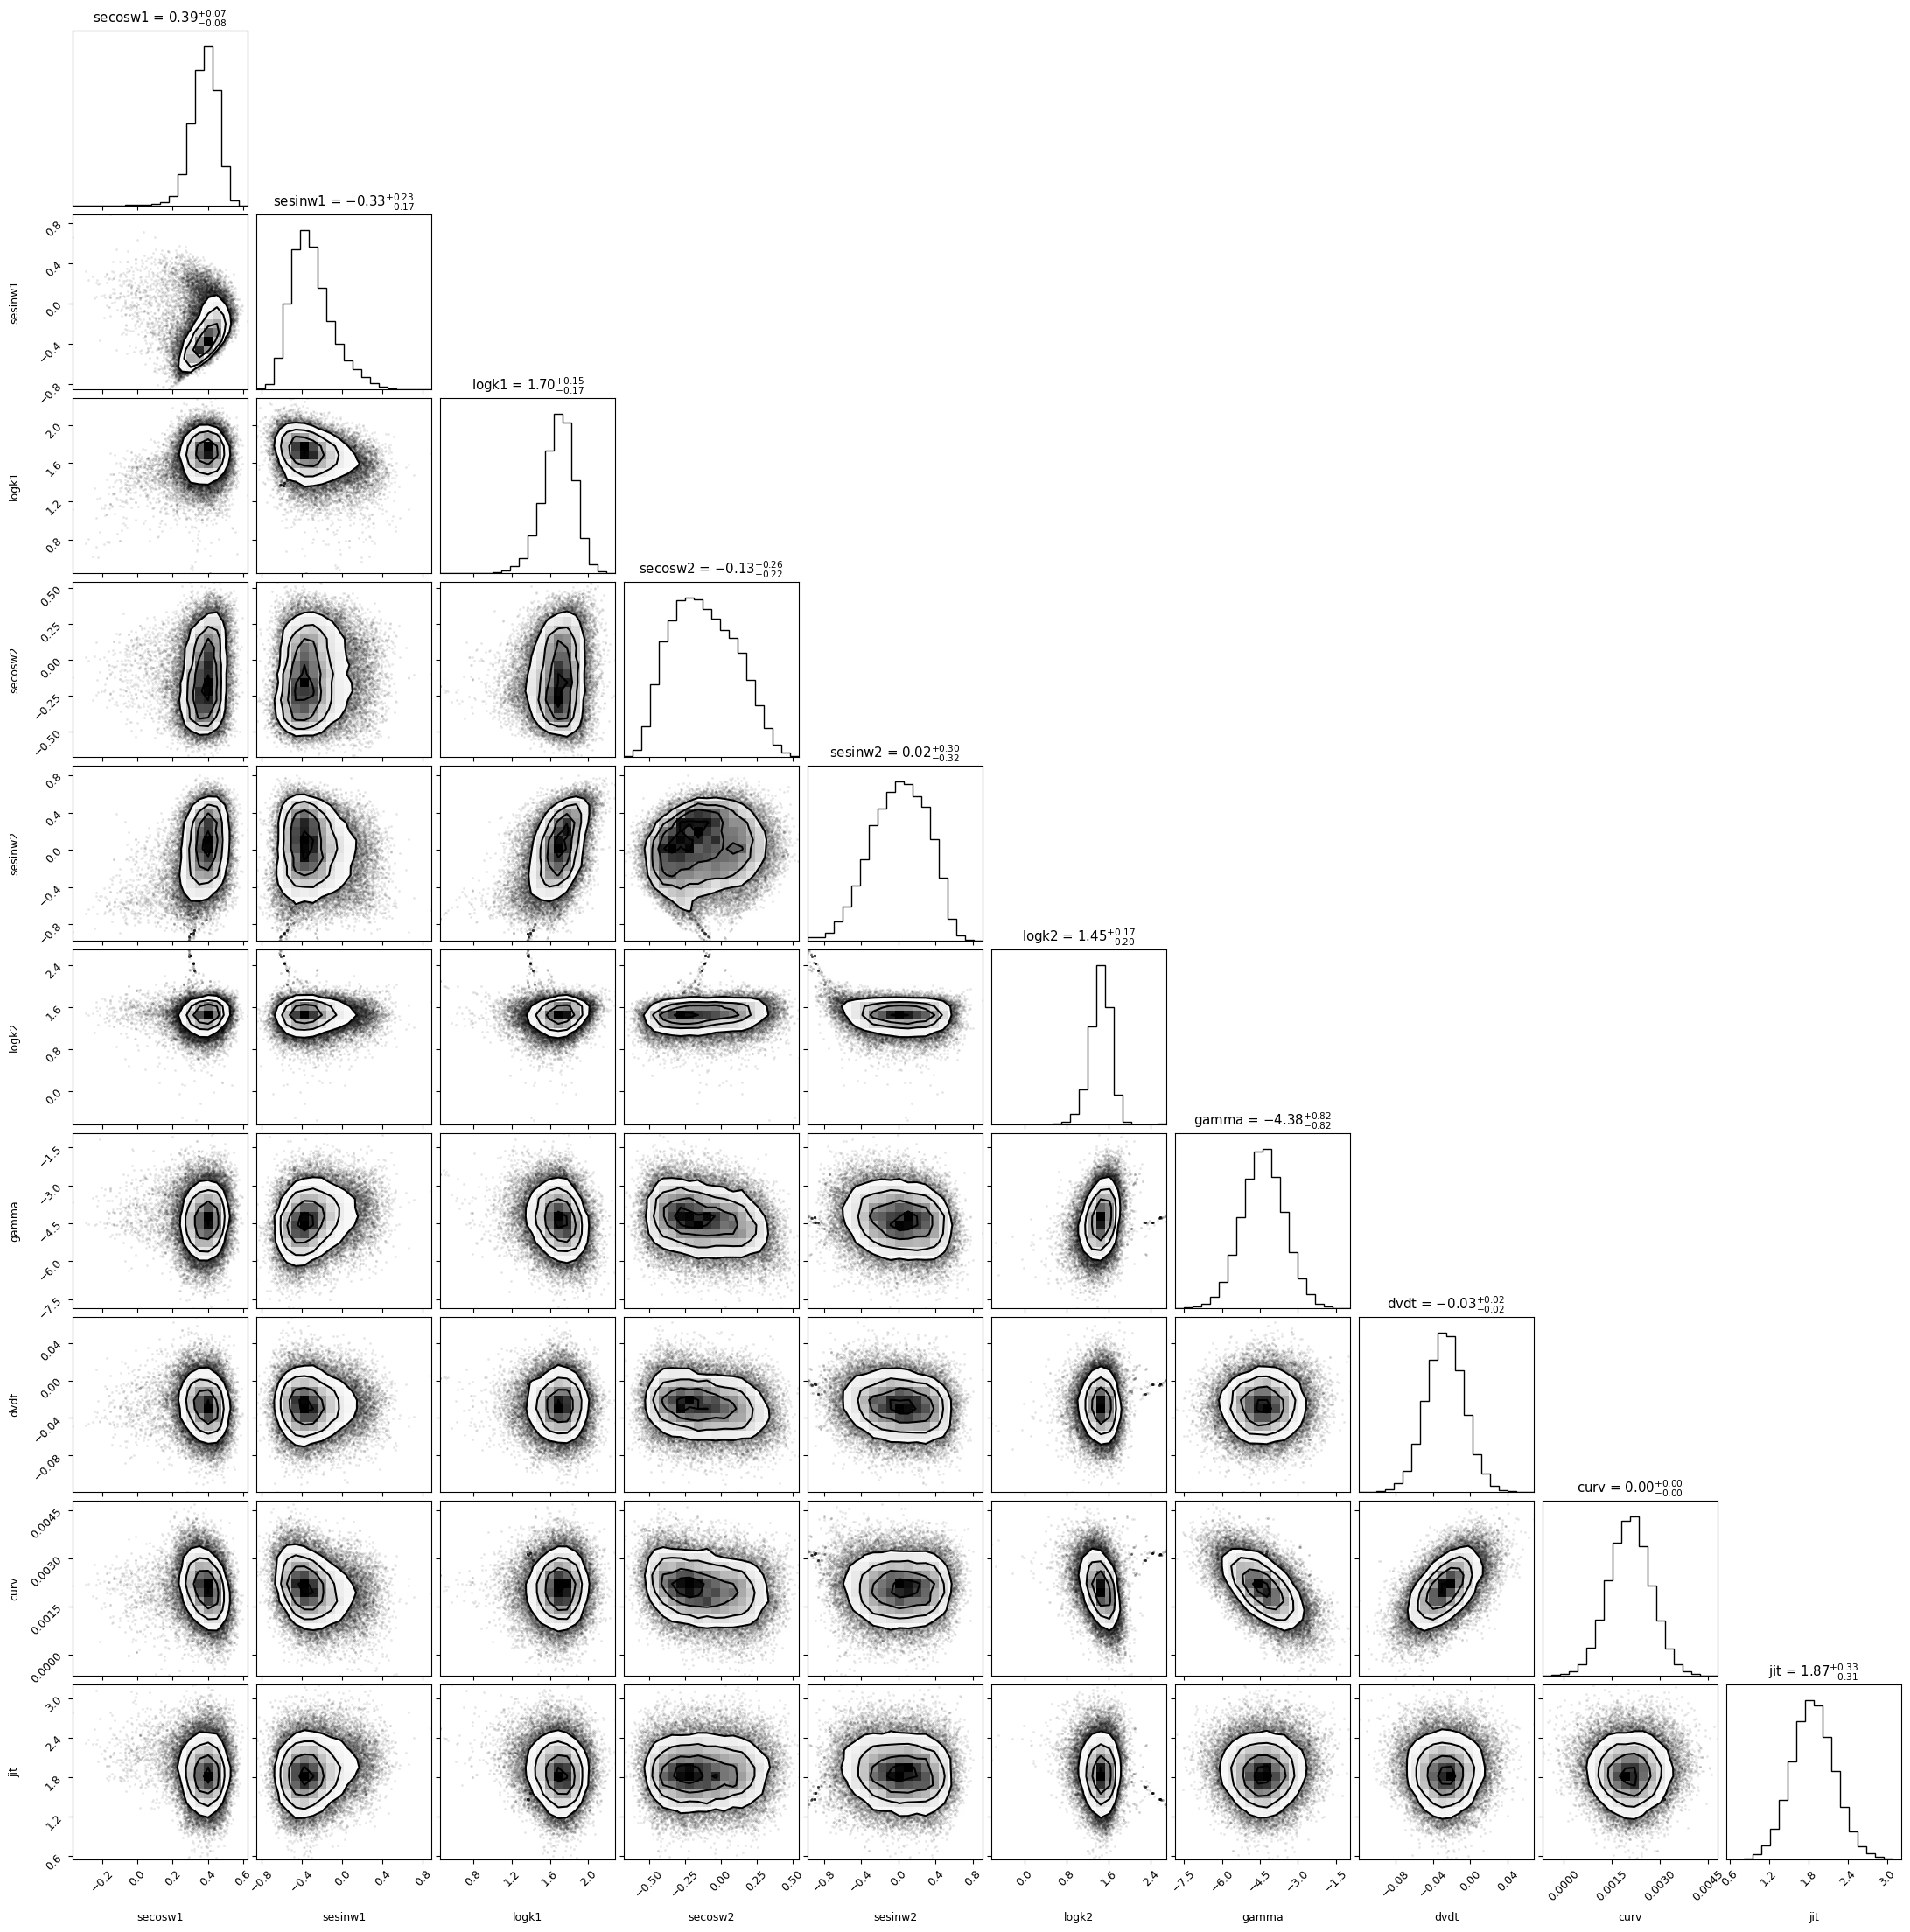

In [24]:
import corner
chains = sampler.get_chain(discard=1000, flat=True, thin=10)
corner.corner(chains, labels=model.keys(), show_titles=True)
plt.show()

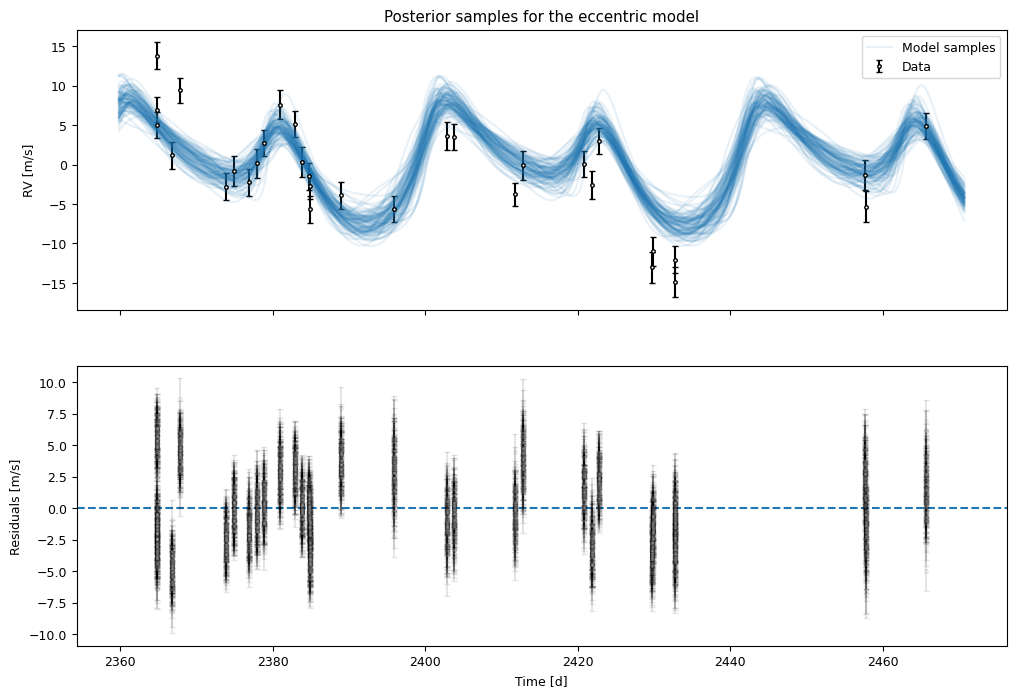

In [25]:
fig, axs = plot_rv(model, chains.T)
axs[0].set_title("Posterior samples for the eccentric model")
plt.show()

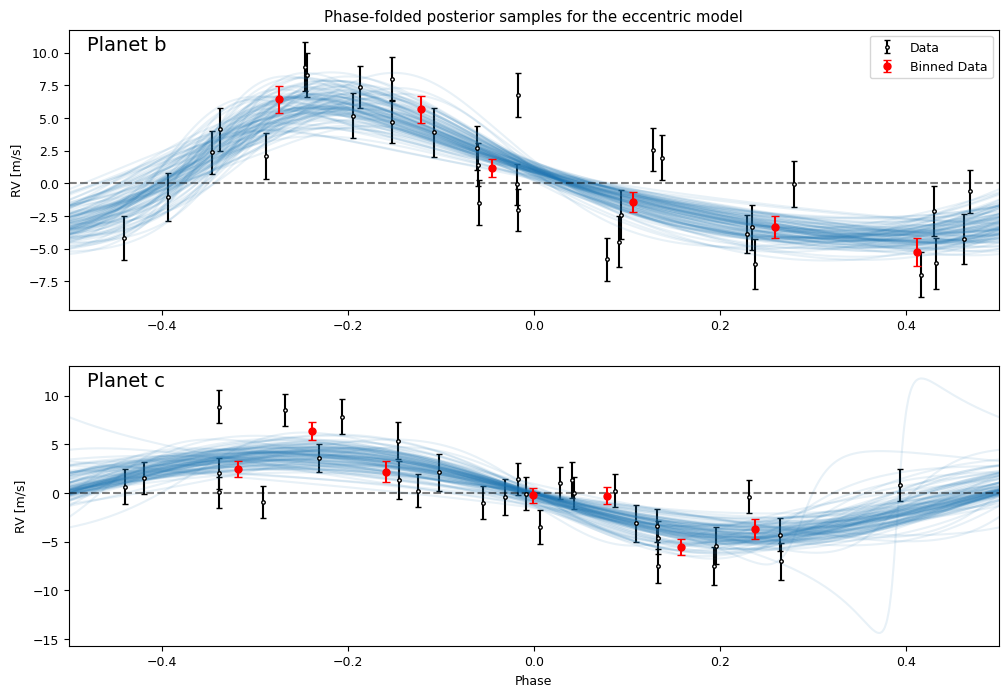

In [26]:
fig,axs = plot_phase(model, chains.T)
axs[0].set_title("Phase-folded posterior samples for the eccentric model")
plt.show()

## Orbit without fixed parameters

Instead of freezing some parameters, let us see what happens if we let them all vary.
For parameters with good external contraints, we will use Gaussian priors, instead of fixing them.

In [27]:
model = build_model("all")

### Optimization

In [28]:
vary_p = {p: v for p, v in test_p.items() if p in model.vary_p}
res = minimize(lambda p: - model.log_prob(p), np.array(list(vary_p.values())), method="Powell")

invalid value encountered in scalar multiply


In [29]:
opt_p = dict(zip(model.keys(), res.x))

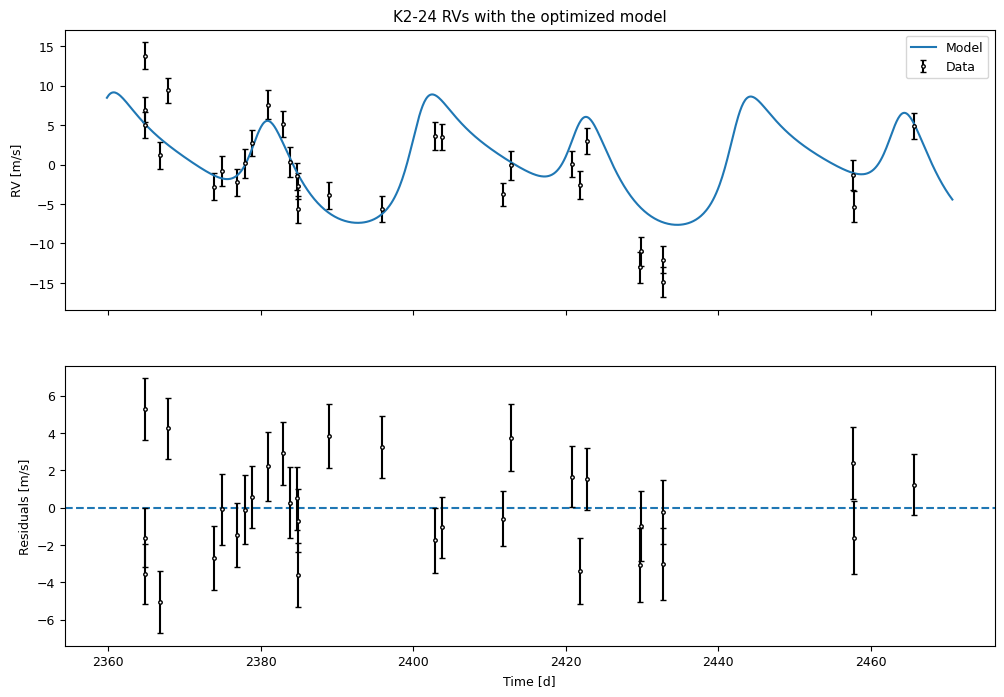

In [30]:
fig, axs = plot_rv(model, opt_p)
axs[0].set_title("K2-24 RVs with the optimized model")
plt.show()

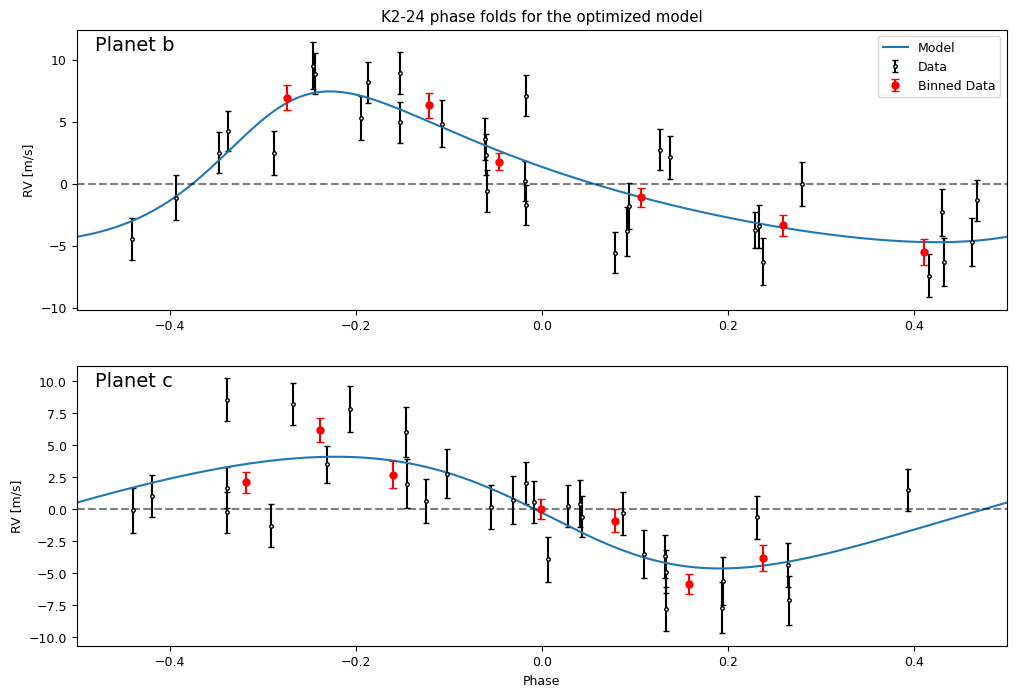

In [31]:
fig, axs = plot_phase(model, opt_p)
axs[0].set_title("K2-24 phase folds for the optimized model")
plt.show()

### Sampling

In [32]:
import emcee

nwalkers = 50
nsteps = 10_000
ndim = model.ndim
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_prob)

In [33]:
rng = np.random.default_rng()
p0 = res.x + 1e-4 * rng.normal(size=(nwalkers, ndim))
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:47<00:00, 93.03it/s]


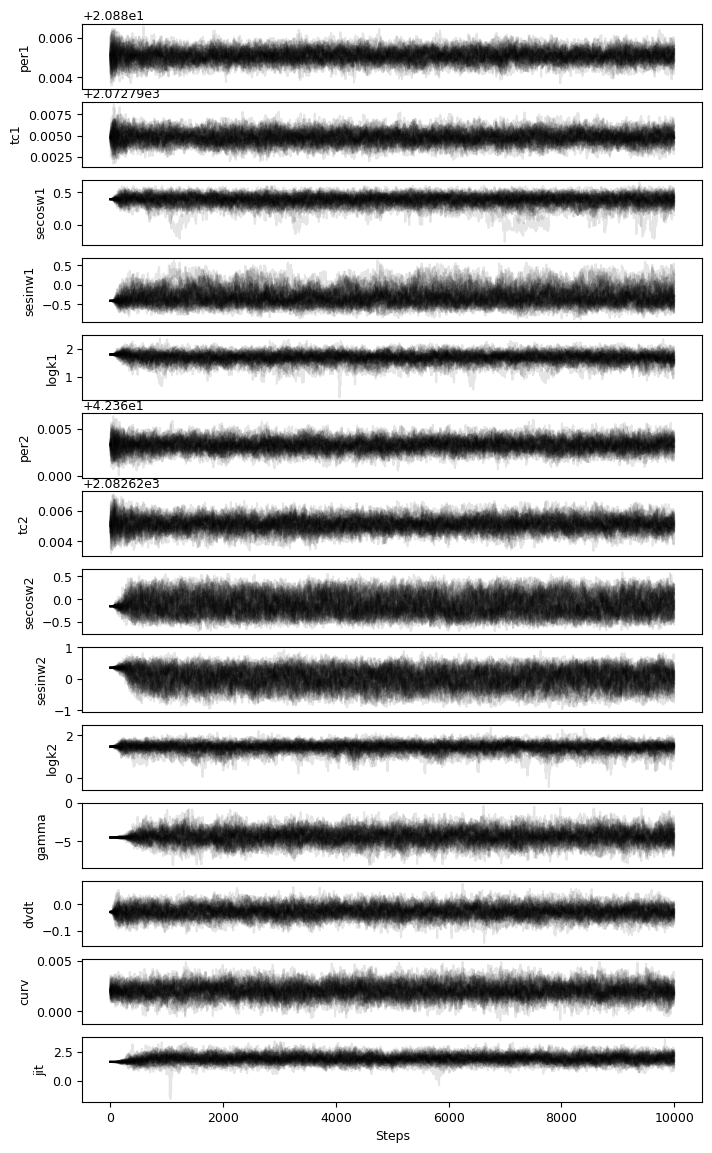

In [34]:
chainplot(sampler.get_chain(), labels=model.keys())
plt.show()

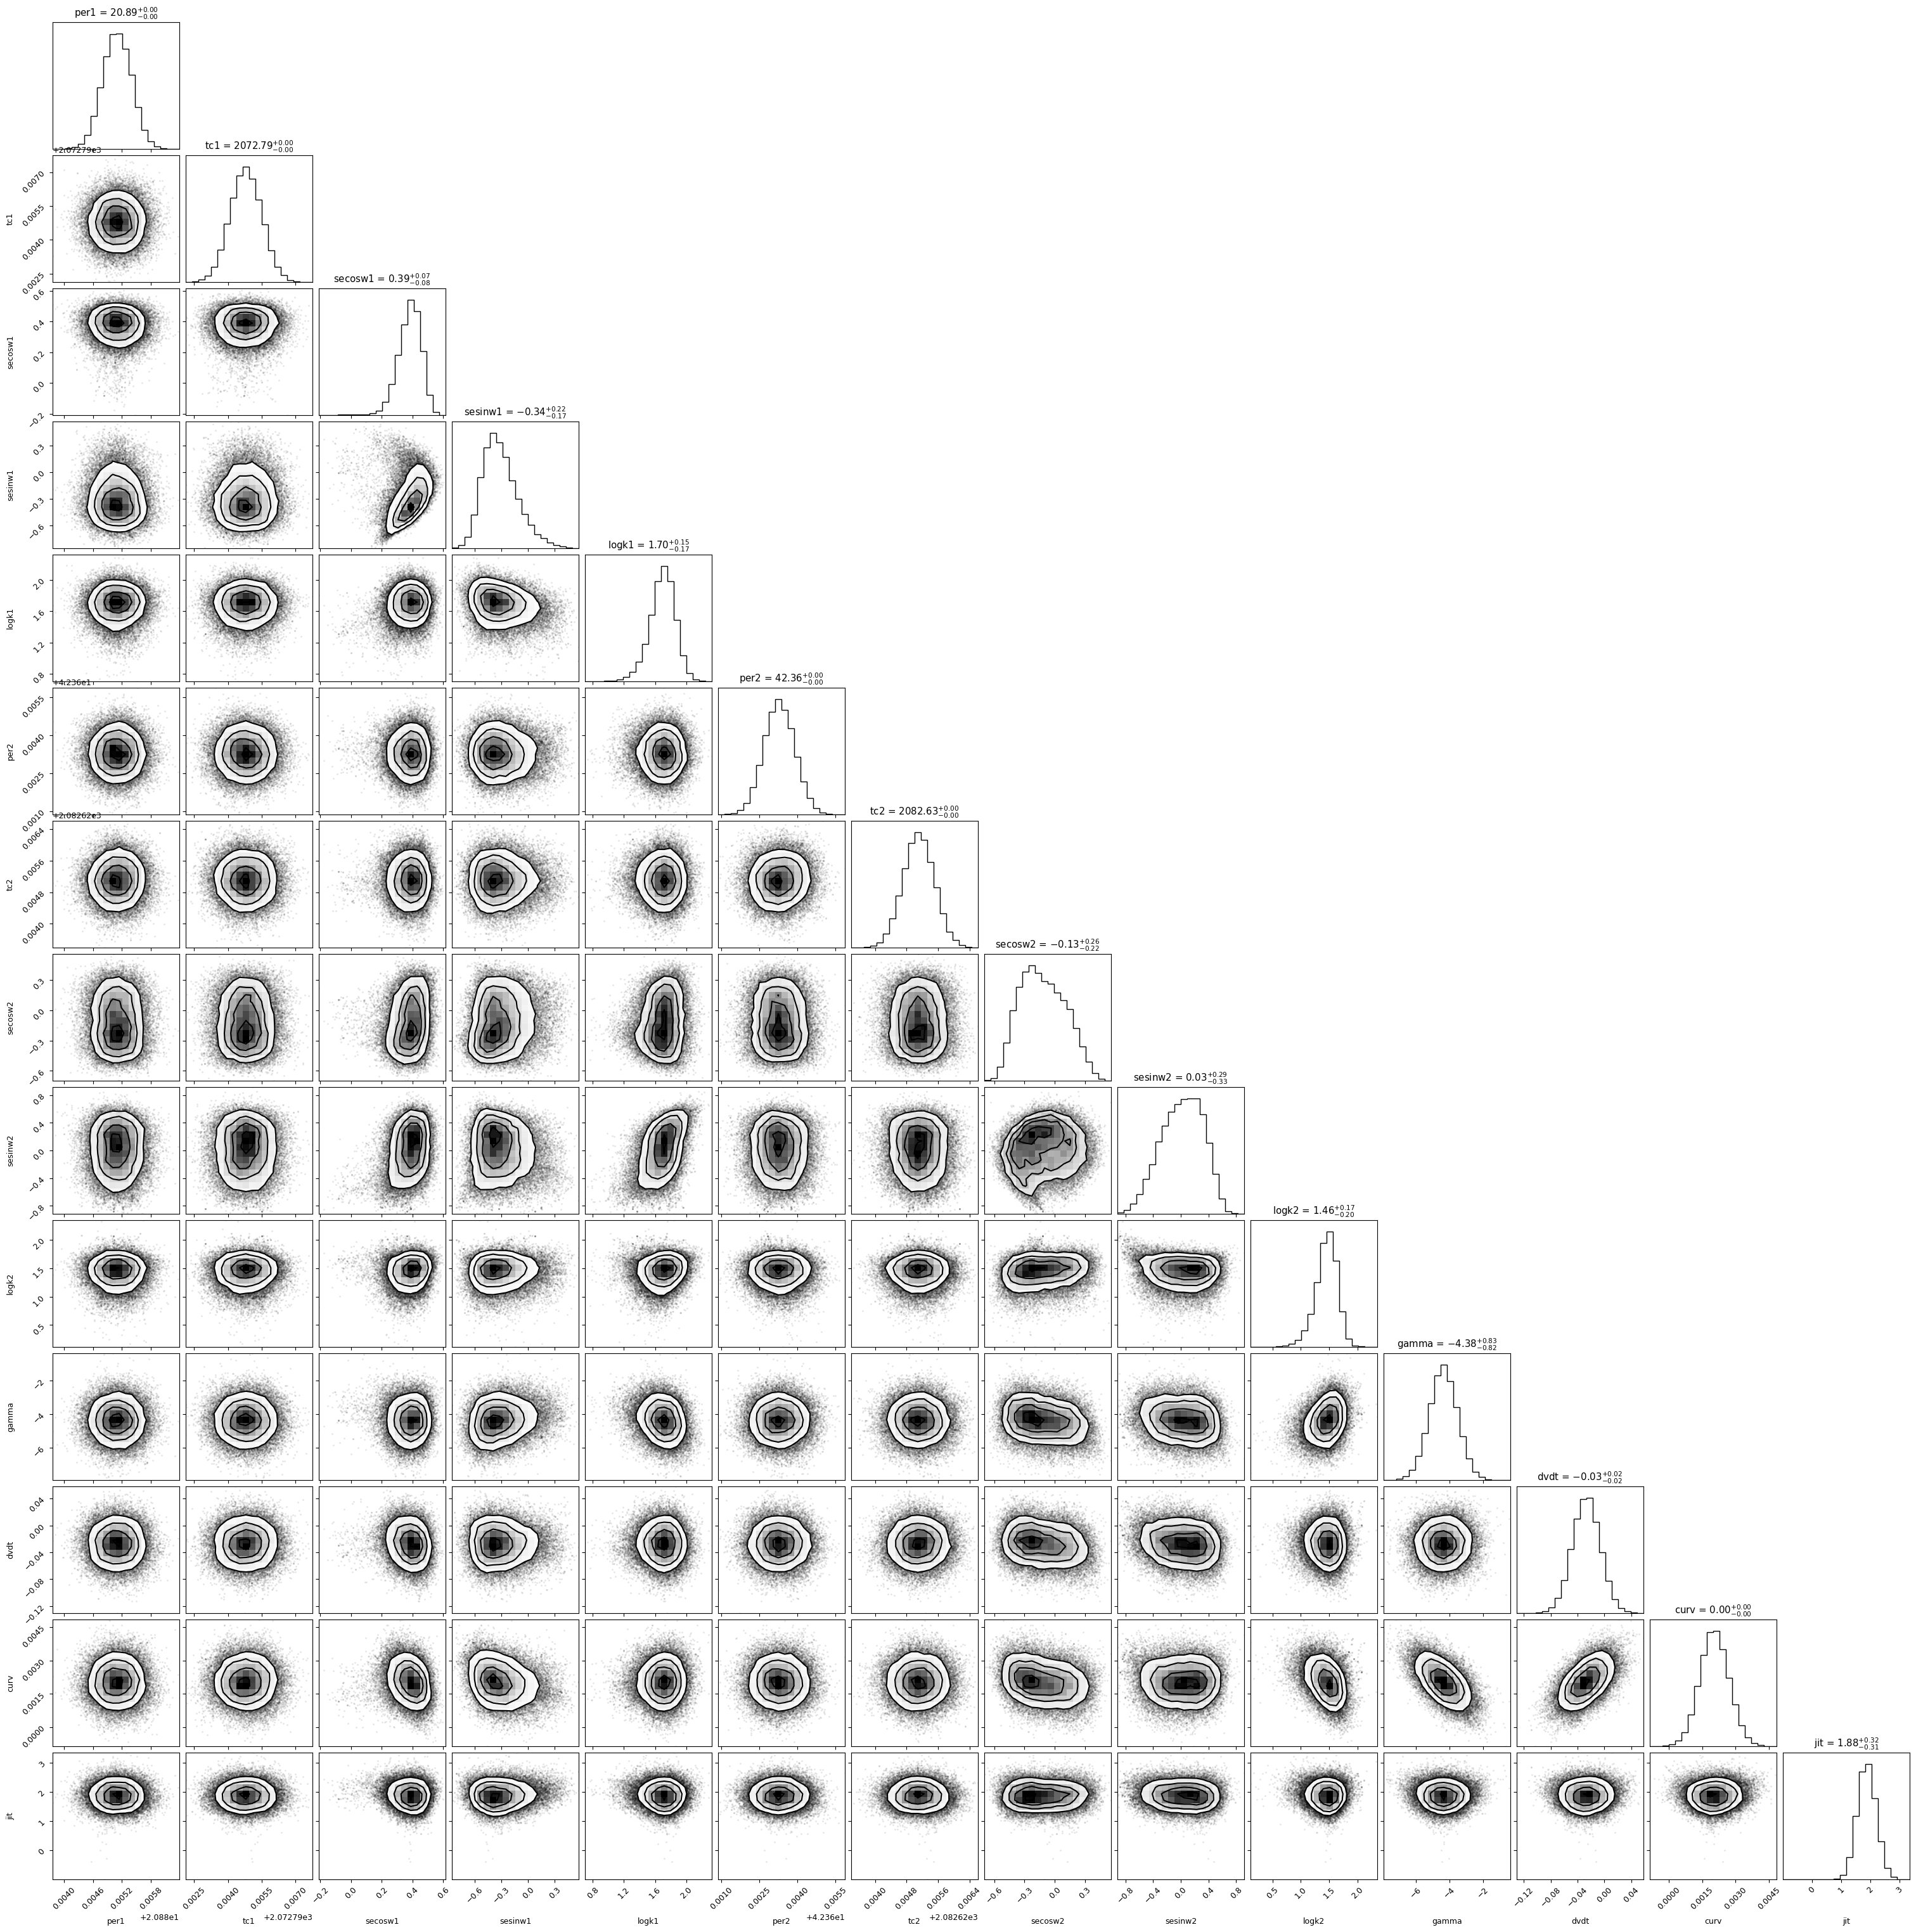

In [35]:
import corner
chains = sampler.get_chain(discard=1000, flat=True, thin=10)
corner.corner(chains, labels=model.keys(), show_titles=True)
plt.show()

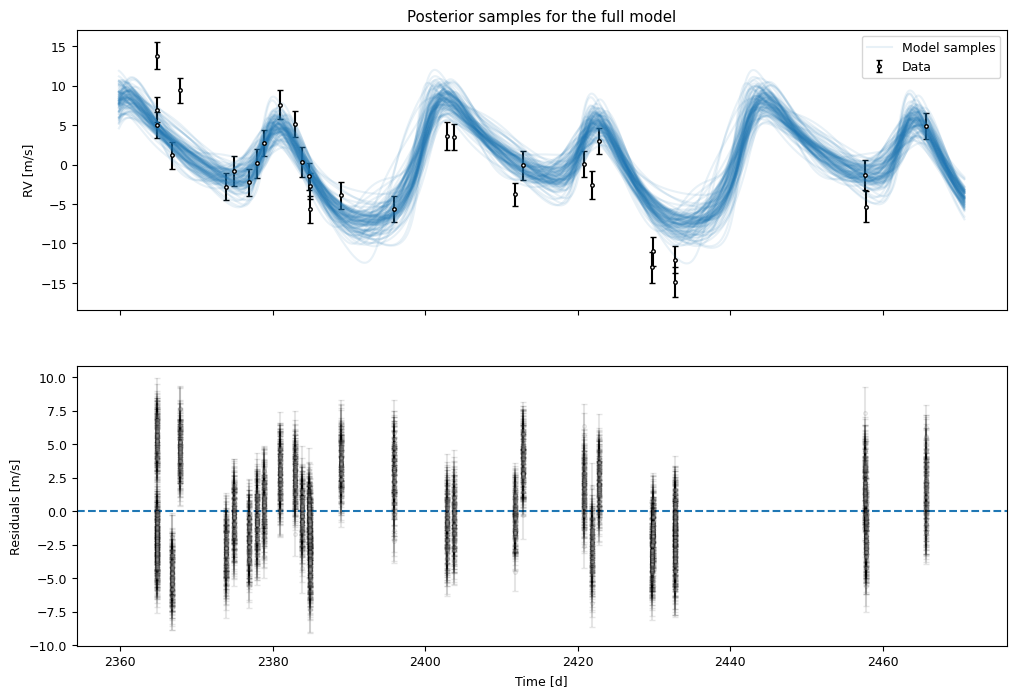

In [36]:
fig, axs = plot_rv(model, chains.T)
axs[0].set_title("Posterior samples for the full model")
plt.show()

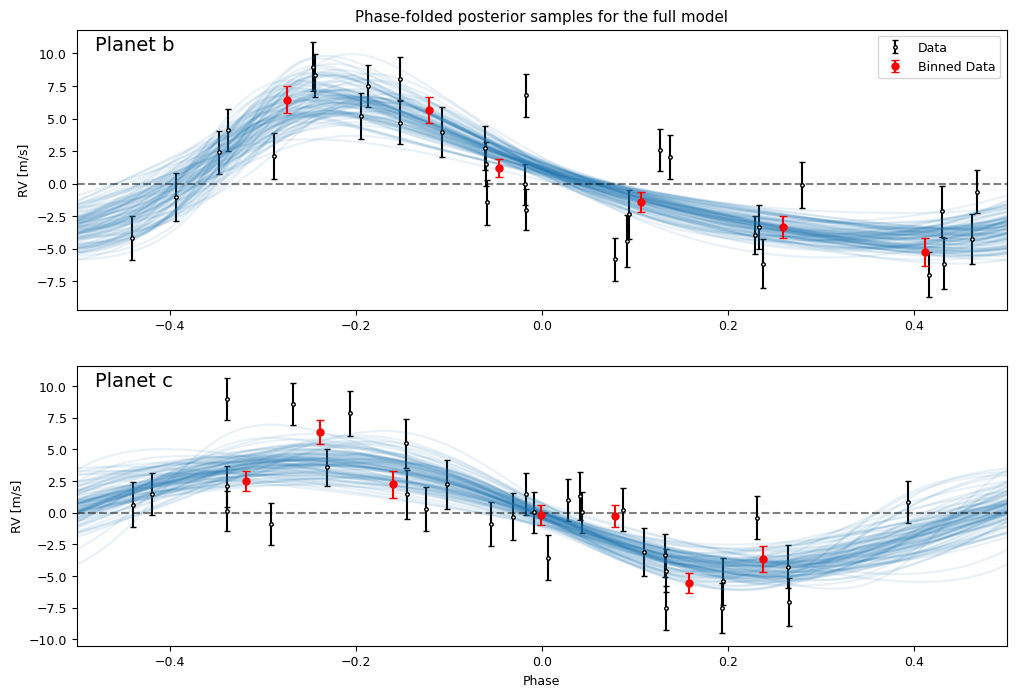

In [37]:
fig, axs = plot_phase(model, chains.T)
axs[0].set_title("Phase-folded posterior samples for the full model")
plt.show()